In [46]:
from Evolution.EvolutionaryLib import BaseChromosome, ChromosomeClassFactory
import random

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [61]:
data = pd.read_csv('datasets/heart.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [48]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)

        new['tree_depth'] = (self['tree_depth'] + other['tree_depth']) // 2

        new['n_trees'] = (self['n_trees'] + other['n_trees']) // 2

        return new

    def mutate(self, rate=0.3):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.tree_depth = new._tree_depth.get()
        else:
            new.tree_depth = self.tree_depth

        if random.random() < rate:
            new.n_trees = new._n_trees.get()
        else:
            new.n_trees = self.n_trees
        return new

chromosome_factory = ChromosomeClassFactory(
        tree_depth=list(range(2, 20)), 
        n_trees=list(range(10, 250))
    )

In [53]:
def evaluate_model(chromosome, show_metric=False):
    n_iterations = 4
    metric = 0
    for _ in range(n_iterations):
        model = RandomForestClassifier(n_estimators=chromosome.n_trees, max_depth=chromosome.tree_depth)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metric += accuracy_score(y_test, y_pred)
    metric /= n_iterations

    if show_metric:
        print(f'{metric=}')

    return metric

In [54]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 30
ITERATIONS = 220
best = [None, -float('inf')]

In [55]:
# need for statistic collection 
statistic_best = []
statistic_mean = []

statistic_tree_depth = []
statistic_n_trees = []

# Evolutionary algorithm 

# initial population initialisation 
population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append([c, None])

# evolution process 
for _ in tqdm(range(ITERATIONS)):
    # scoring each chromosome 
    for instance in population:
        if instance[1] is None:
            instance[1] = evaluate_model(instance[0])

    # selection of best instances 
    population = sorted(population, key=lambda x: x[1], reverse=True)[:POPULATION_SIZE // 3]

    statistic_best.append(population[0][1])
    statistic_mean.append(sum(map(lambda x: x[1], population)) / POPULATION_SIZE)

    statistic_tree_depth.append(population[0][0].tree_depth)
    statistic_n_trees.append(population[0][0].n_trees)

    # checking for the best solution 
    if population[0][1] > best[1]:
        best = population[0]

    # filling the population with new genes 
    while len(population) < POPULATION_SIZE:
        r = random.random()
        if r < 0.33:
            population.append([random.choice(population)[0].crossover(random.choice(population)[0]), None])
        elif 0.33 <= r < 0.66:
            population.append([random.choice(population)[0].mutate(), None])
        else:
            population.append([chromosome_factory.generate(MyChromosome), None])

  0%|          | 0/220 [00:00<?, ?it/s]

100%|██████████| 220/220 [55:45<00:00, 15.21s/it] 


In [56]:
print(best[0], f'{best[1]:_}', sep='\n')
evaluate_model(best[0], True)
None

--Chromosome--
tree_depth: 18
n_trees: 16

0.9963414634146341
metric=0.9853658536585366


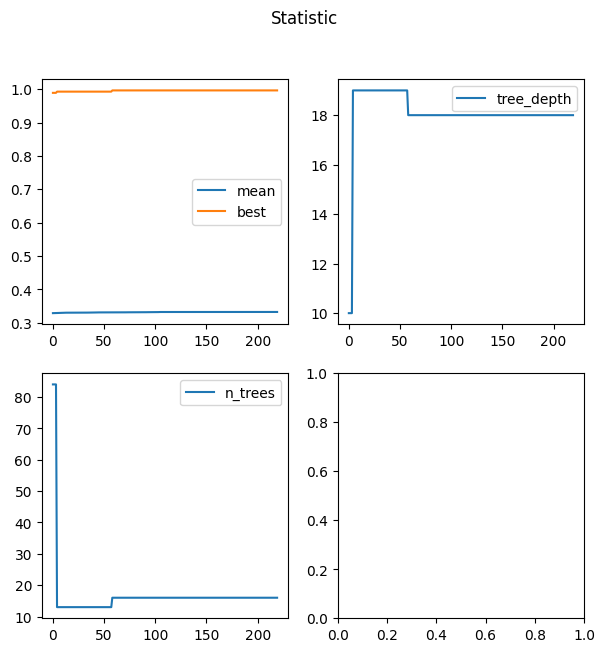

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
fig.suptitle('Statistic')

plt.subplot(2, 2, 1)
plt.plot(statistic_mean, label='mean')
plt.plot(statistic_best, label='best')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(statistic_tree_depth, label='tree_depth')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(statistic_n_trees, label='n_trees')
plt.legend()

plt.show()

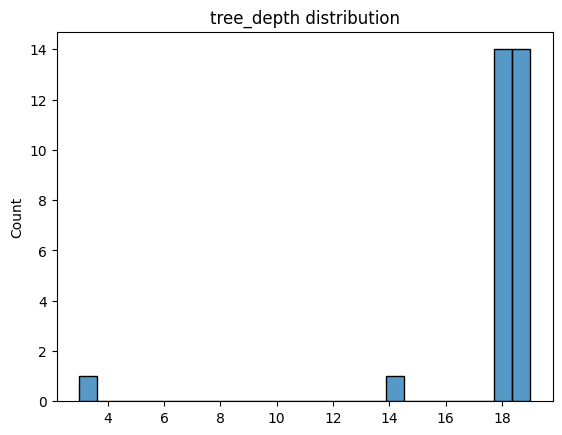

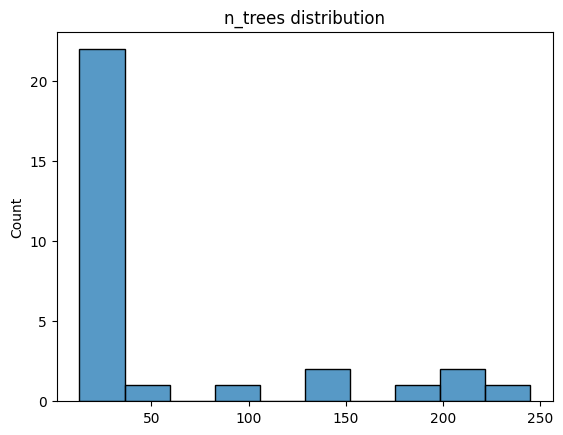

In [58]:
import seaborn as sns 

sns.histplot([c[0].tree_depth for c in population])
plt.title('tree_depth distribution')
plt.show()

sns.histplot([c[0].n_trees for c in population])
plt.title('n_trees distribution')
plt.show()